In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import map_coordinates
from scipy.interpolate import RegularGridInterpolator
from IPython.display import HTML

from KPZ_solver import KPZSolver

# Test KPZ

T = 1.0
L2 error   = 1.969e-05
Max error  = 2.785e-05


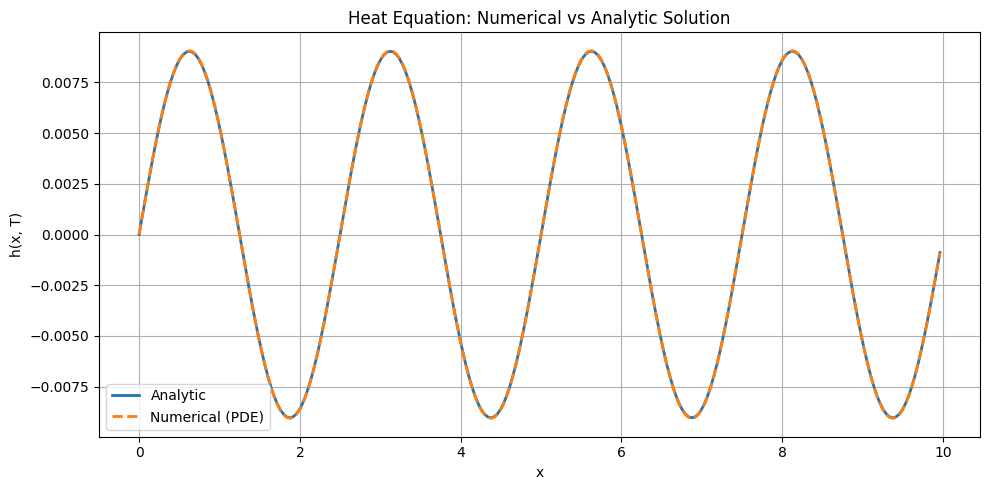

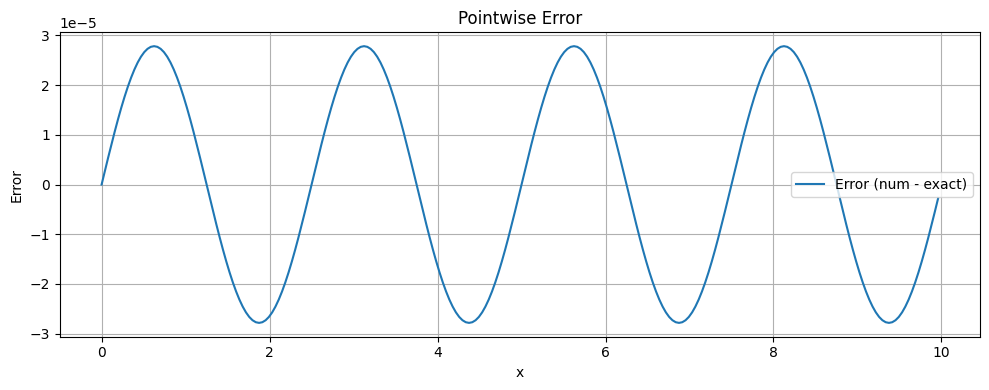

In [3]:
# KPZ setup
L = 10.0
N = 256
dt = 1e-4
T = 1.0
nu = 1.0

# We will test it against an analytical solution so these will be zero
lam = 0.0
noise_strength = 0.0

# Initial condition
m = 4                     
k = 2.0 * np.pi * m / L   
A = 5.0                   
def init_1d(x):
    return A * np.sin(k * x)

# Set it up
solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=1,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_1d,
)

# Run it
snapshots = solver.run(T=T, store_interval=None)

# analytical solution to test against
num_steps = int(T / dt)
t_num = num_steps * dt
x = solver.coords[0]  # 1D grid
h_exact = A * np.exp(-nu * k**2 * t_num) * np.sin(k * x)


h_num = solver.get_height()
l2_error = np.sqrt(np.mean((h_num - h_exact)**2))
max_error = np.max(np.abs(h_num - h_exact))

print(f"T = {t_num}")
print(f"L2 error   = {l2_error:.3e}")
print(f"Max error  = {max_error:.3e}")

#Plot
plt.figure(figsize=(10, 5))
plt.plot(x, h_exact, label="Analytic", linewidth=2)
plt.plot(x, h_num, "--", label="Numerical (PDE)", linewidth=2)
plt.title("Heat Equation: Numerical vs Analytic Solution")
plt.xlabel("x")
plt.ylabel("h(x, T)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x, h_num - h_exact, label="Error (num - exact)")
plt.title("Pointwise Error")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting functions

In [13]:
### Arbitrary projection functions
def sample_line(h, coords, x0, v, num_points=200, t_range=0.5):
    """
    Sample a d-dimensional field h along an arbitrary line,
    keeping only points within the domain.
    """

    d = h.ndim
    x0 = np.array(x0)
    v = np.array(v)

    # Extract 1D axes safely
    grid_axes = [np.unique(coords[i].flatten()) for i in range(d)]
    x_min = np.array([ax.min() for ax in grid_axes])
    x_max = np.array([ax.max() for ax in grid_axes])

    # Interpolator
    interpolator = RegularGridInterpolator(grid_axes, h, bounds_error=False, fill_value=np.nan)

    # Full t_vals
    t_vals = np.linspace(-t_range, t_range, num_points)
    X = np.array([x0 + t*v for t in t_vals])

    # Clip points outside the domain
    mask = np.all((X >= x_min) & (X <= x_max), axis=1)
    t_vals = t_vals[mask]
    X = X[mask]
    h_vals = interpolator(X)

    return t_vals, h_vals, X


def sample_plane(h, coords, x0, v1, v2, n1=100, n2=100, t1_range=0.5, t2_range=0.5):
    """
    Sample a d-dimensional field h on an arbitrary 2D plane,
    keeping a full rectangular grid and clipping t1/t2 to domain bounds.
    """

    d = h.ndim
    x0 = np.array(x0)
    v1 = np.array(v1)
    v2 = np.array(v2)

    # Extract 1D axes
    grid_axes = [np.unique(coords[i].flatten()) for i in range(d)]
    x_min = np.array([ax.min() for ax in grid_axes])
    x_max = np.array([ax.max() for ax in grid_axes])

    def clip_t_range(v, t_range):
        # Compute t_min, t_max such that x0 + t*v stays inside domain
        with np.errstate(divide='ignore', invalid='ignore'):
            t_min_axes = (x_min - x0) / v
            t_max_axes = (x_max - x0) / v
        t_min_axes[v==0] = -np.inf
        t_max_axes[v==0] = np.inf
        t_min = max(-t_range, np.max(np.minimum(t_min_axes, t_max_axes)))
        t_max = min(t_range, np.min(np.maximum(t_min_axes, t_max_axes)))
        return t_min, t_max

    t1_min, t1_max = clip_t_range(v1, t1_range)
    t2_min, t2_max = clip_t_range(v2, t2_range)

    # Create clipped regular grid
    t1_vals = np.linspace(t1_min, t1_max, n1)
    t2_vals = np.linspace(t2_min, t2_max, n2)
    T1, T2 = np.meshgrid(t1_vals, t2_vals, indexing='ij')

    # Build interpolator
    interpolator = RegularGridInterpolator(grid_axes, h, bounds_error=False, fill_value=np.nan)

    # Sample field
    X_plane = x0 + T1[..., None]*v1 + T2[..., None]*v2  # shape (n1, n2, d)
    h_plane = interpolator(X_plane)

    return t1_vals, t2_vals, h_plane, X_plane

###PLOT OPTION 1. 1D Slice
def plot_1d_line(t_vals, h_vals, title="1D Slice"):
    plt.figure(figsize=(8,4))
    plt.plot(t_vals, h_vals)
    plt.xlabel("t (parametric)")
    plt.ylabel("h")
    plt.title(title)
    plt.grid(True)
    plt.show()

#PLOT OPTION 2. 3d surface

def plot_3d_surface(h2d, t1_vals, t2_vals, title="3D Surface"):
    """
    Plot a 3D surface of h2d using t1 and t2 as axes.
    """
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    T1, T2 = np.meshgrid(t1_vals, t2_vals, indexing='ij')
    ax.plot_surface(T1, T2, h2d, cmap='viridis')
    ax.set_xlabel("t1 along v1")
    ax.set_ylabel("t2 along v2")
    ax.set_zlabel("h")
    ax.set_title(title)
    plt.show()

#PLOT OPTION 3. 2d heatmap
def plot_2d_heatmap(h2d, t1_vals, t2_vals, title="2D Plane Slice"):
    """
    Plot a 2D heatmap of h2d using t1 and t2 as axes.
    """
    plt.figure(figsize=(6,5))
    extent = (t1_vals.min(), t1_vals.max(), t2_vals.min(), t2_vals.max())
    plt.imshow(h2d.T, origin='lower', aspect='auto', cmap='viridis', extent=extent)
    plt.colorbar(label="h")
    plt.xlabel("t1 along v1")
    plt.ylabel("t2 along v2")
    plt.title(title)
    plt.show()

#PLOT OPTION 3. 2d heatmap (gradient)
def plot_gradient_magnitude(h2d, t1_vals, t2_vals, title="|∇h| Heatmap"):
    """
    Plot the magnitude of the gradient of h2d on a 2D heatmap with t1 and t2 axes.
    """
    gx, gy = np.gradient(h2d)
    mag = np.sqrt(gx**2 + gy**2)

    plt.figure(figsize=(6,5))
    extent = (t1_vals.min(), t1_vals.max(), t2_vals.min(), t2_vals.max())
    plt.imshow(mag.T, origin='lower', aspect='auto', cmap='magma', extent=extent)
    plt.colorbar(label="|∇h|")
    plt.xlabel("t1 along v1")
    plt.ylabel("t2 along v2")
    plt.title(title)
    plt.show()


from matplotlib.animation import FuncAnimation

def animate_1d(t_vals_list, h_vals_list, title="1D Line Animation", interval=200):
    fig, ax = plt.subplots(figsize=(8,4))
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(t_vals_list[0].min(), t_vals_list[0].max())
    y_min = min([h.min() for h in h_vals_list])
    y_max = max([h.max() for h in h_vals_list])
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("t (parametric)")
    ax.set_ylabel("h")
    ax.set_title(title)
    ax.grid(True)

    def update(frame):
        line.set_data(t_vals_list[frame], h_vals_list[frame])
        return line,

    anim = FuncAnimation(fig, update, frames=len(t_vals_list), interval=interval, blit=True)
    plt.show()
    return anim


def animate_2d_heatmap(h_planes_list, t1_vals, t2_vals, title="2D Heatmap Animation", interval=200):
    fig, ax = plt.subplots(figsize=(6,5))
    extent = (t1_vals.min(), t1_vals.max(), t2_vals.min(), t2_vals.max())
    im = ax.imshow(h_planes_list[0].T, origin='lower', aspect='auto', cmap='viridis', extent=extent)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("h")
    ax.set_xlabel("t1 along v1")
    ax.set_ylabel("t2 along v2")
    ax.set_title(title)

    # FORCE full axis limits
    ax.set_xlim(t1_vals.min(), t1_vals.max())
    ax.set_ylim(t2_vals.min(), t2_vals.max())

    def update(frame):
        im.set_data(h_planes_list[frame].T)
        # ensure extent is preserved each frame
        im.set_extent(extent)
        return [im]

    anim = FuncAnimation(fig, update, frames=len(h_planes_list), interval=interval, blit=True)
    plt.show()
    return anim

def animate_3d_surface(h_planes_list, t1_vals, t2_vals, title="3D Surface Animation", interval=200):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    T1, T2 = np.meshgrid(t1_vals, t2_vals, indexing='ij')

    z_min = min([h.min() for h in h_planes_list])
    z_max = max([h.max() for h in h_planes_list])
    ax.set_zlim(z_min, z_max)
    ax.set_xlim(t1_vals.min(), t1_vals.max())
    ax.set_ylim(t2_vals.min(), t2_vals.max())
    ax.set_xlabel("t1 along v1")
    ax.set_ylabel("t2 along v2")
    ax.set_zlabel("h")
    ax.set_title(title)

    surf = [ax.plot_surface(T1, T2, h_planes_list[0], cmap='viridis')]

    def update(frame):
        surf[0].remove()  # remove previous surface
        surf[0] = ax.plot_surface(T1, T2, h_planes_list[frame], cmap='viridis')
        return surf

    anim = FuncAnimation(fig, update, frames=len(h_planes_list), interval=interval, blit=False)
    return anim




# Original Fake solver test

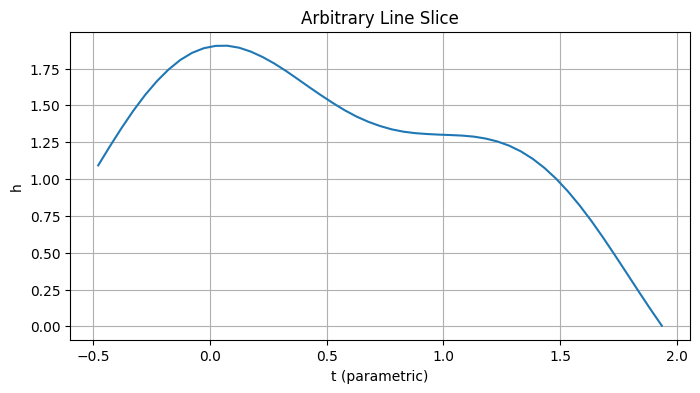

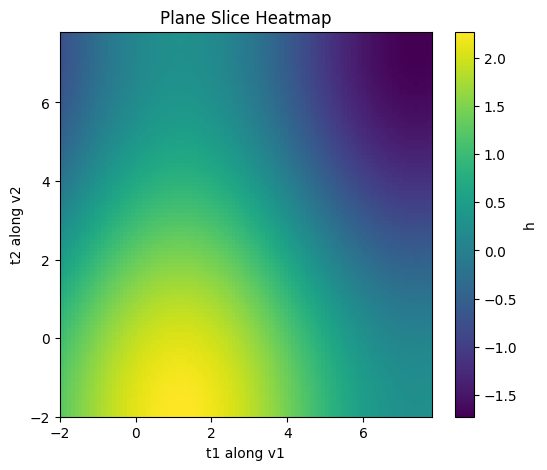

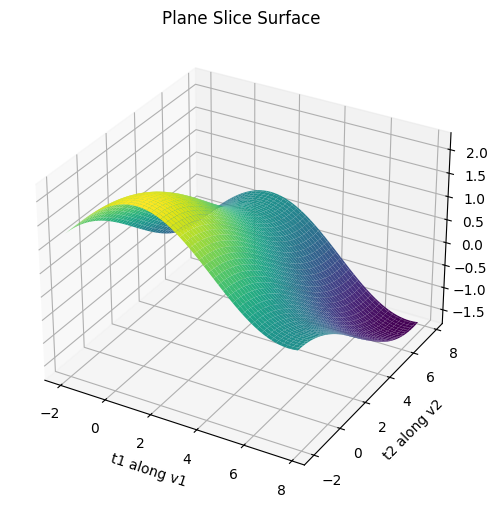

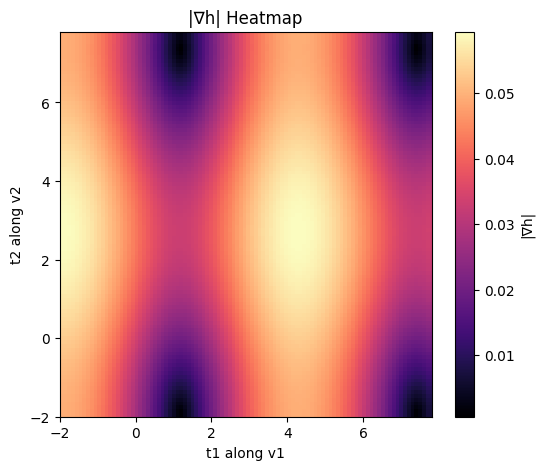

In [14]:
# Create a fake KPZ solver with 2D domain
class FakeSolver:
    def __init__(self):
        self.d = 3
        self.L = (10,10,10)
        self.N = (50,50,50)

        xs = np.linspace(0,10,50,endpoint=False)
        ys = np.linspace(0,10,50,endpoint=False)
        zs = np.linspace(0,10,50,endpoint=False)

        self.coords = np.meshgrid(xs, ys, zs, indexing='ij')

        # Fake height field
        X, Y, Z = self.coords
        self.h = np.sin(X/2) + np.cos(Y/3) + 0.3*np.sin(Z)

solver = FakeSolver()

num_snapshots = 10
snapshots = [solver.h + 0.05*i for i in range(num_snapshots)]

x0 = [2,2,2]              # center of domain
v = [3,0,4]              # arbitrary direction

t_vals, h_vals, X = sample_line(solver.h, solver.coords, x0, v, t_range=5)
plot_1d_line(t_vals, h_vals, "Arbitrary Line Slice")

x0 = [2,2,2]
v1 = [1,0,0]
v2 = [0,1,0]

t_range = 10
t1_vals, t2_vals, h_plane, X_plane = sample_plane(solver.h, solver.coords, x0, v1, v2, t1_range=t_range, t2_range=t_range)

# 2D Heatmap
plot_2d_heatmap(h_plane, t1_vals, t2_vals, "Plane Slice Heatmap")

# 3D Surface
plot_3d_surface(h_plane, t1_vals, t2_vals, "Plane Slice Surface")

# Gradient magnitude
plot_gradient_magnitude(h_plane, t1_vals, t2_vals, "|∇h| Heatmap")

Collected 20 snapshots


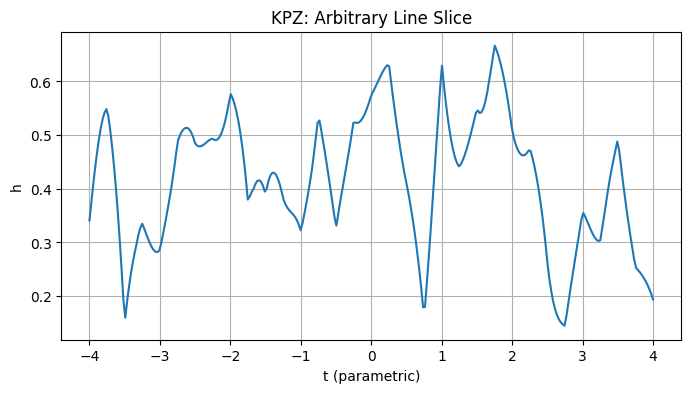

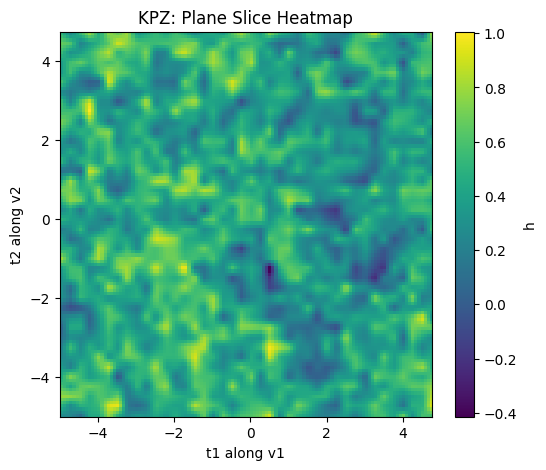

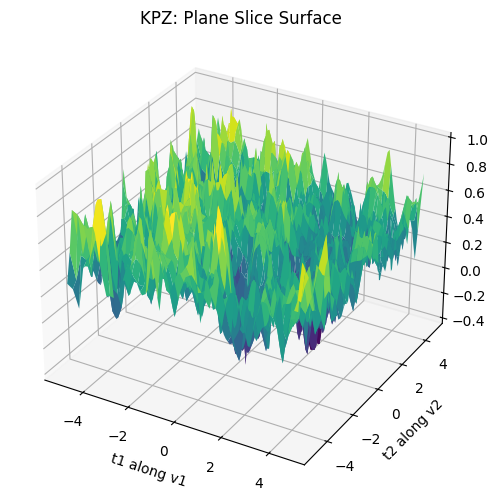

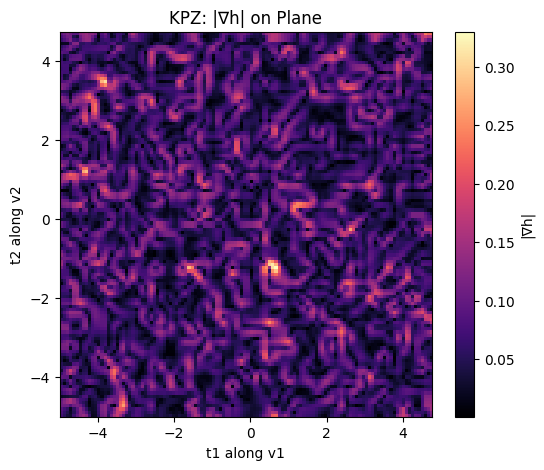

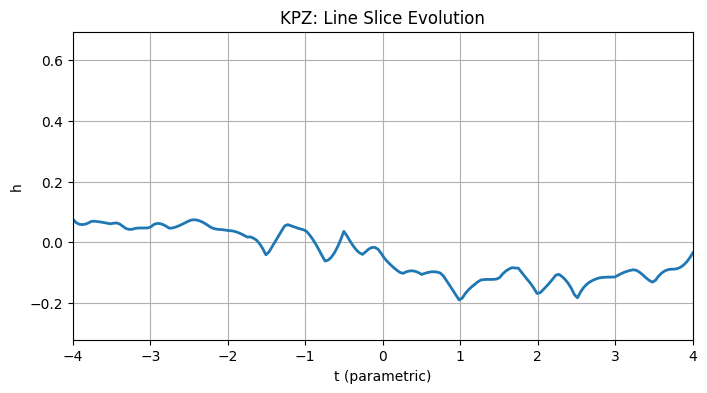

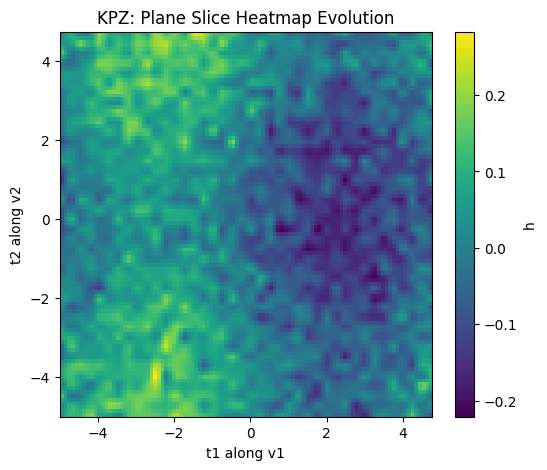

In [15]:
# -----------------------------
# Example: KPZ in 3D, then use your sampling + plotting functions
# -----------------------------

# --- KPZ setup ---
L = (10.0, 10.0, 10.0)     # 3D domain
N = (40, 40, 40)           # resolution (keep modest so it runs fast)
dt = 5e-4
T = 0.5                    # final time
nu = 1.0
lam = 2.0
noise_strength = 0.3
d = 3

# Initial condition: small random perturbation around flat
def init_3d(x, y, z):
    return 0.1 * np.sin(2*np.pi*x/L[0]) + 0.05 * np.cos(2*np.pi*y/L[1]) \
           + 0.02 * np.random.default_rng(0).standard_normal(x.shape)

solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=d,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_3d,
)

# Run and collect snapshots for possible animations
store_interval = 50
snapshots = solver.run(T=T, store_interval=store_interval)
coords = solver.coords

print(f"Collected {len(snapshots)} snapshots")

# Use the last snapshot for static slices
h_last = snapshots[-1]

# -----------------------------
# 1D line slice through the KPZ field
# -----------------------------
x0 = [L[0]/2, L[1]/2, L[2]/2]   # center of domain
v  = [1.0, 0.5, -0.3]           # arbitrary direction

t_vals, h_vals, X_line = sample_line(
    h_last,
    coords,
    x0=x0,
    v=v,
    num_points=300,
    t_range=4.0,
)

plot_1d_line(t_vals, h_vals, title="KPZ: Arbitrary Line Slice")

# -----------------------------
# 2D plane slice through the KPZ field
# -----------------------------
x0_plane = [L[0]/2, L[1]/2, L[2]/2]  # center again
v1 = [1.0, 0.0, 0.0]                 # along x
v2 = [0.0, 1.0, 0.0]                 # along y

t_range = 5.0   # parametric range along v1, v2
t1_vals, t2_vals, h_plane, X_plane = sample_plane(
    h_last,
    coords,
    x0=x0_plane,
    v1=v1,
    v2=v2,
    n1=120,
    n2=120,
    t1_range=t_range,
    t2_range=t_range,
)

# 2D heatmap
plot_2d_heatmap(h_plane, t1_vals, t2_vals, title="KPZ: Plane Slice Heatmap")

# 3D surface
plot_3d_surface(h_plane, t1_vals, t2_vals, title="KPZ: Plane Slice Surface")

# Gradient magnitude heatmap
plot_gradient_magnitude(h_plane, t1_vals, t2_vals, title="KPZ: |∇h| on Plane")

# -----------------------------
# Optional: animations over time (using your animation helpers)
# -----------------------------

# Build line slices over all snapshots for 1D animation
t_vals_list = []
h_vals_list = []
for h_snap in snapshots:
    t_tmp, h_tmp, _ = sample_line(h_snap, coords, x0, v, num_points=200, t_range=4.0)
    t_vals_list.append(t_tmp)
    h_vals_list.append(h_tmp)

anim1d = animate_1d(t_vals_list, h_vals_list, title="KPZ: Line Slice Evolution", interval=150)

# Build plane slices over all snapshots for 2D heatmap animation
h_planes_list = []
for h_snap in snapshots:
    _, _, h_pl, _ = sample_plane(h_snap, coords, x0_plane, v1, v2,
                                 n1=100, n2=100,
                                 t1_range=t_range, t2_range=t_range)
    h_planes_list.append(h_pl)

anim2d = animate_2d_heatmap(h_planes_list, t1_vals, t2_vals,
                            title="KPZ: Plane Slice Heatmap Evolution",
                            interval=150)

# If you want animated 3D surface (heavier to render):
# anim3d = animate_3d_surface(h_planes_list, t1_vals, t2_vals,
#                             title="KPZ: Plane Slice Surface Evolution",
#                             interval=200)

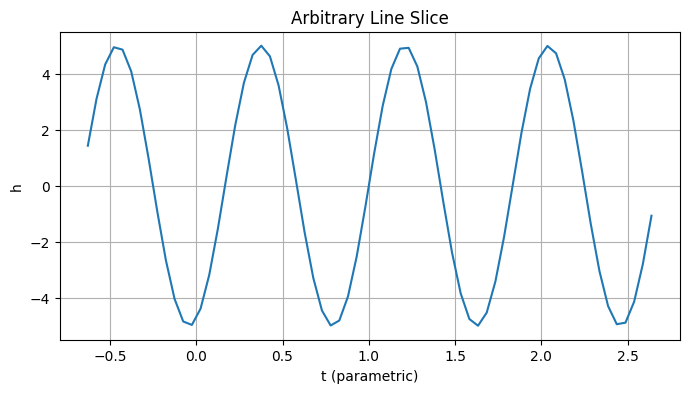

In [11]:
# KPZ setup
L = 10.0
N = 256
dt = 1e-4
T = 1.0
nu = 1.0

# We will test it against an analytical solution so these will be zero
lam = 5.0
noise_strength = 1.0

# Initial condition
m = 4                     
k = 2.0 * np.pi * m / L   
A = 5.0                   
def init_1d(x):
    return A * np.sin(k * x)

# Set it up
solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=1,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_1d,
)

x0 = [2]              # center of domain
v = [3]              # arbitrary direction

t_vals, h_vals, X = sample_line(solver.h, solver.coords, x0, v, t_range=5)
plot_1d_line(t_vals, h_vals, "Arbitrary Line Slice")